# Workbook for handwriting recognition

## Section 1: Dataset evaluation
### Using the EMNIST letter dataset create simple network to classify letters
#### If you don't have emnist set you can download from [Kaggle](https://www.kaggle.com/crawford/emnist)

In [1]:
### Add a 'space' class
import tensorflow as tf
from tensorflow import keras as k
from tensorflow.keras import models, layers
import csv
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import sklearn

## Load test set for visualisation
emnist = pd.read_csv('./emnist/emnist-balanced-test.csv')
#data = loadmat('./emnist/emnist-balanced-test.csv')

In [2]:
## Split data into image and label
x_test = emnist.values[:,1:] # Actual image
y_test = emnist.values[:,0] # Label
n_samples = y_test.shape[0]
y_test_dict = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt"
label = [y_test_dict[a] for a in y_test]

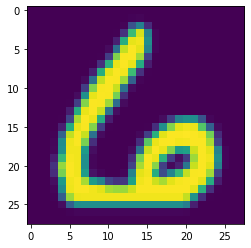

Label:  6


In [3]:
# Select random value
for l in range(1):
    rand_sample = random.randint(0,n_samples)
    test_img = x_test[rand_sample,:].reshape((28,28),order='F')
    plt.imshow(test_img)
    plt.show()
    print('Label: ', label[rand_sample])

In [4]:
# Load actual training set - just letters
from sklearn.model_selection import train_test_split
raw_data = pd.read_csv("emnist/emnist-letters-train.csv")
train, validate = train_test_split(raw_data, test_size=0.1) # change this split however you want

train_data = train.values[:,1:]
train_lab = train.values[:,0]-1 # For some reason class defs start at 1!!
n_train = train_data.shape[0]
validate_data = validate.values[:,1:]
validate_lab = validate.values[:,0]-1 # As for train_lab
n_validate = validate_data.shape[0]

In [5]:
# Create small convnet
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation='relu', input_shape=(28,28,1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(26,activation='softmax'))

In [7]:
# Train model on dataset
from tensorflow.keras.utils import to_categorical
x_train = train_data.reshape((n_train,28,28,1),order='F')
x_train = x_train.astype('float32')
x_train /= 255
x_validate = validate_data.reshape((n_validate,28,28,1),order='F')
x_validate = x_validate.astype('float32')
x_validate /= 255

# Convert labels to categories
y_train = to_categorical(train_lab,26)
y_validate = to_categorical(validate_lab,26)

In [8]:
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(x_train,y_train,epochs=5,batch_size=64)
test_loss, test_acc = model.evaluate(x_validate,y_validate)
print('Loss:',test_loss,'Accuracy:',test_acc)

Epoch 1/5
1249/1249 [==============================] - 6s 5ms/step - loss: 1.0515 - accuracy: 0.6788
Epoch 2/5
1249/1249 [==============================] - 6s 5ms/step - loss: 0.4879 - accuracy: 0.8478
Epoch 3/5
1249/1249 [==============================] - 7s 5ms/step - loss: 0.3899 - accuracy: 0.8789
Epoch 4/5
1249/1249 [==============================] - 7s 5ms/step - loss: 0.3537 - accuracy: 0.8918
Epoch 5/5
278/278 [==============================] - 1s 4ms/step - loss: 0.2312 - accuracy: 0.9287
Loss: 0.2312336415052414 Accuracy: 0.928716242313385


In [9]:
# Test on test set
test = pd.read_csv("emnist/emnist-letters-test.csv")
print(test.shape)
test_data = test.values[:,1:]
test_lab = test.values[:,0]-1
n_test = test_data.shape[0]
x_test = test_data.reshape((n_test,28,28,1),order='F')
x_test = x_test.astype('float32')
x_test /= 255
y_test = to_categorical(test_lab,26)

test_loss, test_acc = model.evaluate(x_test,y_test)
print('Loss:',test_loss,'Accuracy:',test_acc)

(14799, 785)
463/463 [==============================] - 1s 3ms/step - loss: 0.2742 - accuracy: 0.9123
Loss: 0.274162620306015 Accuracy: 0.9122913479804993


## Section 2 - Combining letters into words
### The above simple network gives over 90% classification accuracy but we need to be able to read words and guess how many letters are in the word

### Use a sliding window over several letters to see what we get

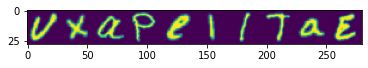

V X A P E L L T A E 


In [10]:
# Create random word of specified length
word_length = 10
rand_int = random.sample(range(n_validate),word_length)
w1 = x_validate[rand_int[0],:,:,:]
for a in rand_int[1:]:
    w1 = np.concatenate((w1,x_validate[a,:,:,:]),axis=1)
w1.shape
plt.imshow(w1[:,:,0])
plt.show()
#dict = "ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt"
dict = "ABCDEFGHIJKLMNOPQRSTUVWXYZ!"
out=[print(dict[validate_lab[a]],end=' ') for a in rand_int];print('')
#out=[print(validate_lab[a],end=' ') for a in rand_int]

X 99.83550906181335


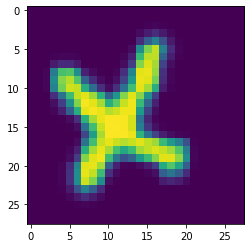

X 99.85918402671814


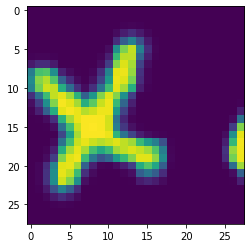

P 99.97672438621521


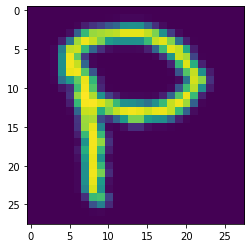

P 99.99961853027344


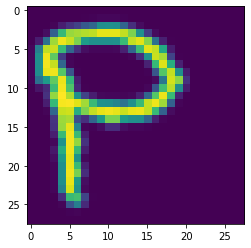

P 99.99570846557617


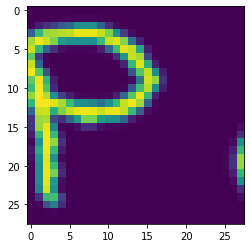

R 99.96356964111328


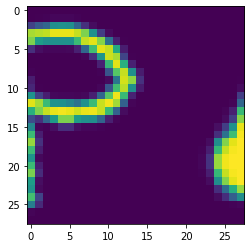

E 99.41627383232117


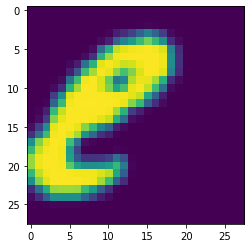

E 99.65537786483765


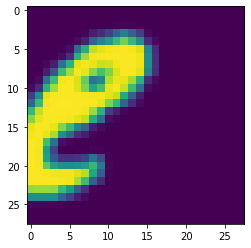

T 99.73316192626953


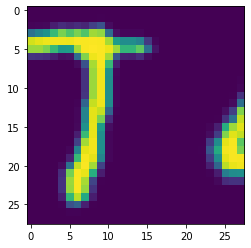

A 99.98100399971008


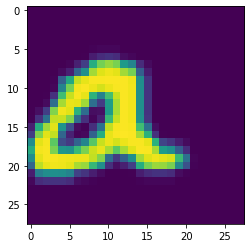

A 99.98918771743774


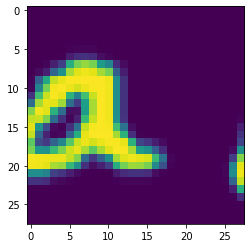

In [11]:
## Slide classifier over selected random letters
win_size = np.array((28,28))
word_size = w1.shape[0:2]
x_pos = 0
skip = 2
while x_pos < word_size[1]-word_size[0]:
    ans = model.predict(np.expand_dims(w1[:,x_pos:x_pos+28,:],axis=0))
    x_pos += 1+skip
    if np.max(ans)>0.99:
        print(dict[np.argmax(ans)],100*np.max(ans))
        plt.imshow(w1[:,x_pos:x_pos+28,0])
        plt.show()
        

## Need to retrain model so that there is a class for spaces 

In [12]:
# Start by creating new dataset by randomly choosing two letters and taking half of each
# Approx 3400 datapoints per class so go for that
space_class_train = np.ndarray((3400,28,28,1))
space_class_val = np.ndarray((340,28,28,1))
for i in range(3060): # 3060 because 10pc are in test set
    rand_letters = random.sample(range(n_train),2)
    slice = random.randint(1,6)
    space_class_train[i,:,:14,:] = x_train[rand_letters[0],:,14-slice:-slice,:]
    space_class_train[i,:,14:,:] = x_train[rand_letters[1],:,slice:14+slice,:]
for i in range(340):
    rand_letters = random.sample(range(n_validate),2)
    slice = random.randint(1,6)
    space_class_val[i,:,:14,:] = x_validate[rand_letters[0],:,14-slice:-slice,:]
    space_class_val[i,:,14:,:] = x_validate[rand_letters[1],:,slice:14+slice,:]

In [13]:
# Use dataset as before
train_lab_s = train_lab
for i in range(space_class_train.shape[0]):
    train_lab_s = np.append(train_lab_s,26)
n_train_s = n_train + space_class_train.shape[0]
validate_lab_s = validate_lab
for i in range(space_class_val.shape[0]):
    validate_lab_s = np.append(validate_lab_s,26)
n_validate_s = n_validate + space_class_val.shape[0]

x_train_s = np.concatenate((x_train,space_class_train))
x_validate_s = np.concatenate((x_validate,space_class_val))

# Convert labels to categories
y_train_s = to_categorical(train_lab_s,27)
y_validate_s = to_categorical(validate_lab_s,27)

In [14]:
# Create model - ensure 27 outputs!!
model_s = models.Sequential()
model_s.add(layers.Conv2D(32,(3,3),activation='relu', input_shape=(28,28,1)))
model_s.add(layers.MaxPooling2D((2,2)))
model_s.add(layers.Conv2D(64,(3,3),activation='relu'))
model_s.add(layers.MaxPooling2D((2,2)))
model_s.add(layers.Conv2D(64,(3,3),activation='relu'))
model_s.add(layers.Flatten())
model_s.add(layers.Dense(64,activation='relu'))
model_s.add(layers.Dropout(0.5))
model_s.add(layers.Dense(27,activation='softmax'))

In [15]:
# Train model
model_s.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
model_s.fit(x_train_s,y_train_s,epochs=5,batch_size=64)
test_loss, test_acc = model_s.evaluate(x_validate_s,y_validate_s)
print('Loss:',test_loss,'Accuracy:',test_acc)

Epoch 1/5
1302/1302 [==============================] - 7s 5ms/step - loss: 1.1307 - accuracy: 0.6616
Epoch 2/5
1302/1302 [==============================] - 6s 4ms/step - loss: 0.5121 - accuracy: 0.8421
Epoch 3/5
1302/1302 [==============================] - 7s 6ms/step - loss: 0.4040 - accuracy: 0.8766
Epoch 4/5
1302/1302 [==============================] - 7s 5ms/step - loss: 0.3658 - accuracy: 0.8912
Epoch 5/5
289/289 [==============================] - 1s 3ms/step - loss: 0.2232 - accuracy: 0.9307
Loss: 0.22315683960914612 Accuracy: 0.9306941628456116


11/11 [==============================] - 0s 7ms/step - loss: 0.0306 - accuracy: 0.9912
Loss: 0.030605604872107506 Accuracy: 0.9911764860153198


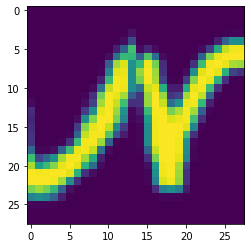

In [16]:
## Test on letters
val_s_only = y_validate_s[-340:,:]
test_loss, test_acc = model_s.evaluate(space_class_val,val_s_only)
print('Loss:',test_loss,'Accuracy:',test_acc)
plt.imshow(space_class_val[20,:,:,0])
plt.show()

## Now let's test that on the slide of letters

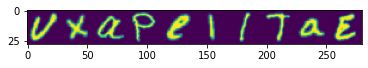

V 96.51638865470886
V 92.55327582359314
! 95.86418271064758
! 99.97171759605408
! 99.99990463256836
! 100.0
! 100.0
! 94.74326968193054
X 81.32497668266296
X 99.6290922164917
X 99.50680732727051
X 88.27061653137207
! 99.9947190284729
! 100.0
! 100.0
! 99.9995231628418
O 18.48035454750061
A 86.79639101028442
A 96.1076557636261
A 94.84941959381104
Z 55.41655421257019
! 96.99925184249878
! 100.0
! 100.0
! 100.0
! 46.43493294715881
F 96.3760495185852
P 99.99418258666992
P 99.99994039535522
P 99.99971389770508
Q 55.85452914237976
! 100.0
! 100.0
! 100.0
! 100.0
I 48.74076247215271
E 62.26118803024292
E 99.57828521728516
E 99.90801811218262
E 98.16229343414307
! 99.99985694885254
! 100.0
! 100.0
! 100.0
! 99.99979734420776
J 60.9096884727478
I 55.86143136024475
L 51.686012744903564
L 80.19869923591614
R 50.48385262489319
! 99.95556473731995
! 100.0
! 99.9575674533844
! 82.79691338539124
I 41.90300703048706
L 71.54821753501892
L 79.06572818756104
L 63.82145285606384
R 32.60907232761383
! 99.9

In [17]:
## Slide classifier over selected random letters
## Seems to work well!!
plt.imshow(w1[:,:,0])
plt.show()
win_size = np.array((28,28))
word_size = w1.shape[0:2]
x_pos = 0
skip = 2
while x_pos < word_size[1]-word_size[0]:
    ans = model_s.predict(np.expand_dims(w1[:,x_pos:x_pos+28,:],axis=0))
    x_pos += 1+skip
    if np.max(ans)>0.0:
        print(dict[np.argmax(ans)],100*np.max(ans))
        #plt.imshow(w1[:,x_pos:x_pos+28,0])
        #plt.show()

## Let's squish the words together more

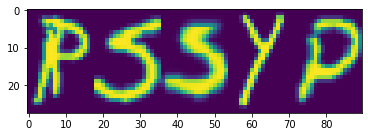

R 85.20501852035522
! 100.0
! 100.0
! 99.99997615814209
S 99.60875511169434
S 99.64585900306702
S 99.19723272323608
! 99.98655319213867
! 100.0
! 100.0
S 93.66957545280457
S 99.44427609443665
S 86.16374731063843
! 99.83670115470886
! 100.0
! 100.0
Y 91.02808833122253
Y 99.73723888397217
! 97.55879044532776
! 100.0
! 99.99998807907104


In [18]:
word_length = 5
rand_int = random.sample(range(n_validate),word_length) # Random letters
rand_width = random.sample(range(1,6),word_length) # Randomly shrink letter
rand_width = [5]
w2 = x_validate[rand_int[0],:,rand_width[0]:-rand_width[0],:]
for b,a in enumerate(rand_int[1:]):
    w2 = np.concatenate((w2,x_validate[a,:,rand_width[0]:-rand_width[0],:]),axis=1)
w2.shape
plt.imshow(w2[:,:,0])
plt.show()

## Test on squished word
win_size = np.array((28,28))
word_size = w2.shape[0:2]
x_pos = 0
skip = 2
while x_pos < word_size[1]-word_size[0]:
    ans = model_s.predict(np.expand_dims(w2[:,x_pos:x_pos+28,:],axis=0))
    x_pos += 1+skip
    if np.max(ans)>0.0:
        print(dict[np.argmax(ans)],100*np.max(ans))

In [ ]:
# Let's think of a better way to look for spaces - find gap between spaces and classify on that
win_size = np.array((28,28))
word_size = w2.shape[0:2]
w2 = np.hstack((w2,np.zeros((28,28,1))))
x_pos = 0
letter_num = 1
space_pos = 0
skip = 1
while x_pos < word_size[1]:
    ans = model_s.predict(np.expand_dims(w2[:,x_pos:x_pos+28,:],axis=0))
    if dict[np.argmax(ans)] == '!':
        if x_pos<14 and x_pos>7:
            window = np.expand_dims(np.hstack((np.zeros((28,14-x_pos,1)),w2[:,0:x_pos+14,:])),axis=0)
        #elif word_size[1]-x_pos<28:
            #print('a')
            #window = np.expand_dims(np.hstack((w2[:,x_pos:,:],np.zeros((28,28-x_pos,1)))),axis=0)
        elif x_pos < 7:
            x_pos += 1+skip
            continue
        else:
            window = np.expand_dims(w2[:,x_pos-14:x_pos+14,:],axis=0)
        lett = model_s.predict(window)
        if dict[np.argmax(lett)] != '!':
            print(dict[np.argmax(lett)], window.shape)
            plt.imshow(window[0,:,:,0])
            plt.show()
    x_pos += 1+skip

In [ ]:
import cv2